In [1]:
from SymPT import RDSymbol, BosonOp, RDBasis, EffectiveFrame, Dagger, Block, display_dict
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

# SymPT Mask

In [3]:
def letter(num):
    # Define the patterns for each letter
    patterns = {
        0: np.array([
            [1, 1, 1],
            [1, 0, 0],
            [1, 1, 1],
            [0, 0, 1],
            [1, 1, 1]
        ]),  # Capital "S"
        1: np.array([
            [0, 0, 0, 0],
            [1, 0, 0, 1],
            [0, 1, 1, 1],
            [0, 0, 0, 1],
            [1, 1, 1, 1]
        ]),  # Lowercase "y"
       2: np.array([
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 1],
            [1, 1, 0, 1, 1],
            [1, 0, 1, 0, 1],
            [1, 0, 0, 0, 1]
        ]), # Lowercase "m"
        3: np.array([
            [1, 1, 1],
            [1, 0, 1],
            [1, 1, 1],
            [1, 0, 0],
            [1, 0, 0]
        ]),  # Capital "P"
        4: np.array([
            [1, 1, 1],
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0]
        ]),  # Capital "T"
        }

    # Return the correct pattern or raise an error if the input is invalid
    if num in patterns:
        return patterns[num]
    else:
        raise ValueError("Input must be a number from 0 to 3.")
space = np.zeros((5,1))
zero_b = np.zeros((5,5)) 
last_pad = np.zeros((12,37))

(37, 37)

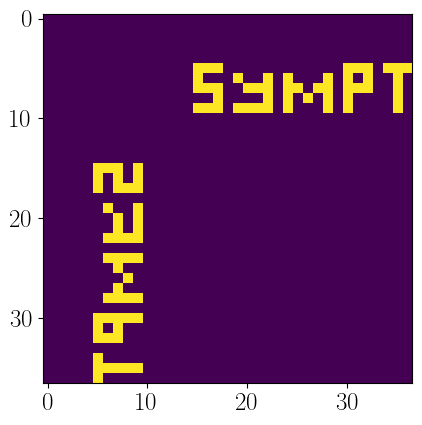

In [4]:
SymPT = np.block(
    [
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, letter(0),space,letter(1),space,letter(2),space,letter(3),space,letter(4)], 
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [last_pad]
    ]
)
SymPT = SymPT + SymPT.T
mask = Block(SymPT)
plt.imshow(SymPT)
SymPT.shape

# Hamiltonian

In [5]:
I = SymPT.shape[0]
J = SymPT.shape[1]
lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]


finite = RDBasis("f", I)

H = sp.zeros(I, J)
lambda_index = 0
for i in range(I):
    for j in range(i, J):  # Loop only over upper triangular part (including diagonal)
        if i == j:
            H[i, j] = omegas[i]  # Diagonal elements
        else:
            H[i, j] = lambdas[lambda_index]
            H[j, i] = lambdas[lambda_index]  # Ensure symmetry
            lambda_index += 1

In [6]:
def substitution_rules(I, J):
    
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1 * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound # np.random.uniform(-bound, bound)            
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas
values, omegas = substitution_rules(I,J)

In [7]:
Eff_Frame = EffectiveFrame(H,None, subspaces = [finite])
# Calculate the effective model using mask up to the second order
Eff_Frame.solve(max_order=2, full_diagonalization=False, mask=mask)
# Obtaining the result in the matrix form
result = H_eff.get_H(return_form = "matrix")

Creating the EffectiveFrame object with matrix form.
The EffectiveFrame object has been initialized successfully.

Effective Frame

╭────────┬────────┬─────────────╮
│  Name  │  Type  │  Dimension  │
├────────┼────────┼─────────────┤
│   f    │ Finite │    37x37    │
╰────────┴────────┴─────────────╯

Effective Hamiltonian: 	Not computed yet. To do so, run `solve` method. 




Solving for each order:  50%|██████      | 1/2 [00:00<00:00,  3.60it/s]


AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'evalf'

In [29]:
isinstance(sp.zeros(*H.shape),sp.Matrix)

True

# Plotting

In [15]:
H_subs = H.subs(values)
inputs = []
inputs += omegas
inputs += lambdas
inputs = sp.Matrix(inputs)

fn = sp.lambdify(inputs, result, "numpy")

NameError: name 'result' is not defined

In [ ]:
vals = inputs.subs(values)
substituted = fn(*vals)

In [ ]:
diag_idx = np.diag_indices(SymPT.shape[0])
substituted = substituted.astype(float)
substituted[substituted == 0] = None

fig, ax = plt.subplots(dpi = 200)
mapp = ax.imshow(substituted, cmap = "inferno")
fig.colorbar(mapp)
#plt.savefig(dir_images+'masked_hamiltonian.pdf',  bbox_inches='tight')

In [ ]:
# Error function
def error(true_spect, eff_spect):
    diff =  eff_spect - true_spect 
    return np.abs(diff / true_spect)

true_spectrum = np.sort(np.array(H.subs(values).diagonalize()[1].diagonal()).astype(float)) # obtaining true spectrum (sorting for correct matching)
effe_spectrum = np.sort(fn(*vals)[diag_idx].astype(float)) 
err_not = error(true_spectrum, np.array(H.diagonal().subs(values)).astype(float))[0] # error of diagonal elements by doing nothing
err_eff = error(true_spectrum, effe_spectrum)[0] # error of effective spectrum

In [ ]:
tmp1 = np.where(SymPT != 0)[0] # getting indices of mask
changed_diags = np.array(list(set(tmp1))) # getting indices of decoupled energies

fig, ax = plt.subplots(dpi = 200)
yes = True
for n, error in enumerate(err_not): 
    #marker = "o"
    #c = "k"
    if n in changed_diags: # if plotting decoupled energy
        marker = "o"
        c = "r"
        ax.scatter(n, error, marker = marker, c = c, s = 30, label = r"$\mathrm{Untransformed}$ $\mathrm{spectrum}$" if yes else None)
        yes = False
    else:
        pass
        #ax.scatter(n, error, marker = marker, c = c, s = 10)
yes = True  
for n, error in enumerate(err_eff): 
    #marker = "D"
    #c = "k"
    if n in changed_diags: # if plotting decoupled energy
        marker = "o"
        c = "b"
        scatter = ax.scatter(n, error, marker = marker, c = c, s = 30, label = r"$\mathrm{Transformed}$ $\mathrm{spectrum}$" if yes else None)
        yes = False
    else:
        #ax.scatter(n, error, marker = marker, c = c, s = 10)
        pass
ax.legend(fontsize=fntsize*0.8, loc=0)
ax.set_xlabel(r"$\mathrm{Eigenvalue}$ $\mathrm{index}$", fontsize = fntsize)
ax.set_ylabel(r"$\left|\frac{E - E_\mathrm{true}}{E_\mathrm{true}}\right|$", fontsize = fntsize)
ax.set_ylim(-0.01,0.3)
#fig.savefig(dir_images+'decoupled_energies_error.pdf',  bbox_inches='tight')